Topic:        Challenge 1

Subject:      Explore MTA turnstile data

Date:         09/29/2018

Name:         Luke Tibbott

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

%matplotlib inline
%config InlineBackend.figure_format = 'svg'

## Part 1: Load data

In [2]:
download = False

if download:

    df_list = []

    dates = ['180526', '180602', '180609', '180616']

    for date in dates:
        df_list.append(pd.read_csv(f'http://web.mta.info/developers/data/nyct/turnstile/turnstile_{date}.txt'))
        print(f'downloading {date} data')
        
    df = pd.concat(df_list)
    df.reset_index(inplace=True, drop=True)
    
    df.to_csv('turnstile.csv')
    
    
else:
    df = pd.read_csv('turnstile.csv')

## Part 2: Convert to datetime

In [3]:
df['DATETIME'] = df['DATE'] + ' ' + df['TIME']

In [4]:
df['DATETIME'] = pd.to_datetime(df['DATETIME'], format='%m/%d/%Y %H:%M:%S')

## Part 3: Calculate entries and exits diffs

In [5]:
df_clean = df.copy()

In [6]:
df_clean.sort_values(by=['C/A', 'UNIT', 'SCP', 'STATION', 'DATETIME'], inplace=True)

In [7]:
df_clean.head()

,Unnamed: 0,C/A,UNIT,SCP,STATION,LINENAME,DIVISION,DATE,TIME,DESC,ENTRIES,EXITS,DATETIME
0,0,A002,R051,02-00-00,59 ST,NQR456W,BMT,05/19/2018,00:00:00,REGULAR,6625470,2245312,2018-05-19 00:00:00
1,1,A002,R051,02-00-00,59 ST,NQR456W,BMT,05/19/2018,04:00:00,REGULAR,6625494,2245314,2018-05-19 04:00:00
2,2,A002,R051,02-00-00,59 ST,NQR456W,BMT,05/19/2018,08:00:00,REGULAR,6625514,2245338,2018-05-19 08:00:00
3,3,A002,R051,02-00-00,59 ST,NQR456W,BMT,05/19/2018,12:00:00,REGULAR,6625595,2245415,2018-05-19 12:00:00
4,4,A002,R051,02-00-00,59 ST,NQR456W,BMT,05/19/2018,16:00:00,REGULAR,6625791,2245481,2018-05-19 16:00:00


In [8]:
df_clean['ENTRIES'] = df_clean.groupby(['C/A', 'UNIT', 'SCP', 'STATION'])['ENTRIES'].diff(periods=-1)*-1

Get rid of all the spaces in the `EXITS` column

In [9]:
df_clean.columns = df_clean.columns.str.strip()

Perform the same operation on `EXITS` as we did on `ENTRIES`.

In [10]:
df_clean['EXITS'] = df_clean.groupby(['C/A', 'UNIT', 'SCP', 'STATION'])['EXITS'].diff(periods=-1)*-1

Filter out data that recorded `ENTRIES` or `EXITS` less than 0 or above 100,000 in a single 4 hour period.

In [11]:
df_clean = df_clean[(df_clean['EXITS'] >= 0) & (df_clean['EXITS'] <= 100000)]

In [12]:
df_clean = df_clean[(df_clean['ENTRIES'] >= 0) & (df_clean['ENTRIES'] <= 100000)]

In [13]:
df_byday = df_clean.groupby(['C/A', 'SCP', 'DATE'])['ENTRIES'].sum().reset_index()

In [14]:
df_byday.head()

,C/A,SCP,DATE,ENTRIES
0,A002,02-00-00,05/19/2018,660.0
1,A002,02-00-00,05/20/2018,536.0
2,A002,02-00-00,05/21/2018,1420.0
3,A002,02-00-00,05/22/2018,1463.0
4,A002,02-00-00,05/23/2018,1447.0


In [15]:
df = df_clean.copy()

## Plot daily time series for a single turnstile

In [16]:
def timeseries_single(df, ca='A002', scp='02-00-00'):
    t = df[(df['C/A'] == ca) & (df['SCP'] == '02-00-00')]
    
    plt.figure(figsize=(10, 6))
    sns.lineplot(t['DATE'], df['ENTRIES'], ci=0)
    plt.title(f'Entries for turnstile with C/A {ca} and SCP {scp}')
    plt.tick_params(axis='x', which='major', rotation = 70)

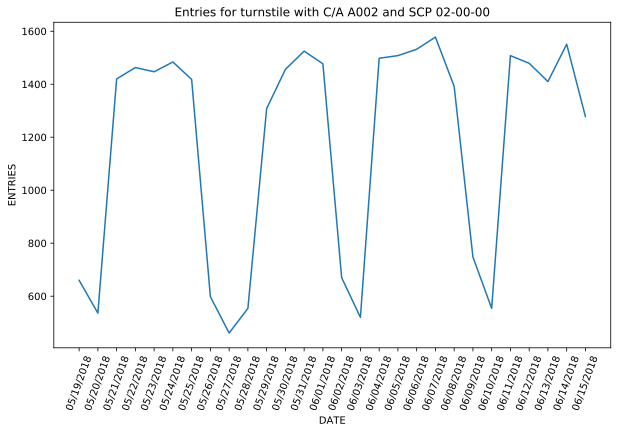

In [17]:
timeseries_single(df_byday)

## Part 5: Group multiple turnstiles together

In [18]:
df_clean.head()

,Unnamed: 0,C/A,UNIT,SCP,STATION,LINENAME,DIVISION,DATE,TIME,DESC,ENTRIES,EXITS,DATETIME
0,0,A002,R051,02-00-00,59 ST,NQR456W,BMT,05/19/2018,00:00:00,REGULAR,24.0,2.0,2018-05-19 00:00:00
1,1,A002,R051,02-00-00,59 ST,NQR456W,BMT,05/19/2018,04:00:00,REGULAR,20.0,24.0,2018-05-19 04:00:00
2,2,A002,R051,02-00-00,59 ST,NQR456W,BMT,05/19/2018,08:00:00,REGULAR,81.0,77.0,2018-05-19 08:00:00
3,3,A002,R051,02-00-00,59 ST,NQR456W,BMT,05/19/2018,12:00:00,REGULAR,196.0,66.0,2018-05-19 12:00:00
4,4,A002,R051,02-00-00,59 ST,NQR456W,BMT,05/19/2018,16:00:00,REGULAR,227.0,39.0,2018-05-19 16:00:00


In [19]:
df_grpd = df_clean.groupby(['C/A', 'SCP', 'UNIT', 'DATE']).sum()

In [20]:
df_grpd.head()

Unnamed: 0  ENTRIES  EXITS
C/A  SCP      UNIT DATE                                  
A002 02-00-00 R051 05/19/2018          15    660.0  225.0
                   05/20/2018          51    536.0  195.0
                   05/21/2018          87   1420.0  549.0
                   05/22/2018         123   1463.0  566.0
                   05/23/2018         159   1447.0  576.0

## Part 6: Group by station

Similarly, combine everything in each station, and come up with a time series of [(date1, count1),(date2,count2),...] type of time series for each STATION, by adding up all the turnstiles in a station.

In [21]:
df_clean.head()

,Unnamed: 0,C/A,UNIT,SCP,STATION,LINENAME,DIVISION,DATE,TIME,DESC,ENTRIES,EXITS,DATETIME
0,0,A002,R051,02-00-00,59 ST,NQR456W,BMT,05/19/2018,00:00:00,REGULAR,24.0,2.0,2018-05-19 00:00:00
1,1,A002,R051,02-00-00,59 ST,NQR456W,BMT,05/19/2018,04:00:00,REGULAR,20.0,24.0,2018-05-19 04:00:00
2,2,A002,R051,02-00-00,59 ST,NQR456W,BMT,05/19/2018,08:00:00,REGULAR,81.0,77.0,2018-05-19 08:00:00
3,3,A002,R051,02-00-00,59 ST,NQR456W,BMT,05/19/2018,12:00:00,REGULAR,196.0,66.0,2018-05-19 12:00:00
4,4,A002,R051,02-00-00,59 ST,NQR456W,BMT,05/19/2018,16:00:00,REGULAR,227.0,39.0,2018-05-19 16:00:00


In [22]:
df_stns = df_clean.groupby(['DATE', 'STATION']).sum().reset_index()

In [23]:
df_stns.head()

,DATE,STATION,Unnamed: 0,ENTRIES,EXITS
0,05/19/2018,1 AV,1834230,19241.0,21979.0
1,05/19/2018,103 ST,11564091,19170.0,12915.0
2,05/19/2018,103 ST-CORONA,9851841,14090.0,11290.0
3,05/19/2018,104 ST,2054706,1582.0,797.0
4,05/19/2018,110 ST,5751018,6968.0,6530.0


## Part 7: Plot the time series for a station

In [24]:
def timeseries_station(df, stn='59 ST'):
    s = df[df['STATION'] == stn]
    
    plt.figure(figsize=(10, 6))
    sns.lineplot(s['DATE'], s['ENTRIES'])
    
    plt.title(f'Daily entries at {stn} station')
    plt.tick_params(axis='x', which='major', rotation = 70)

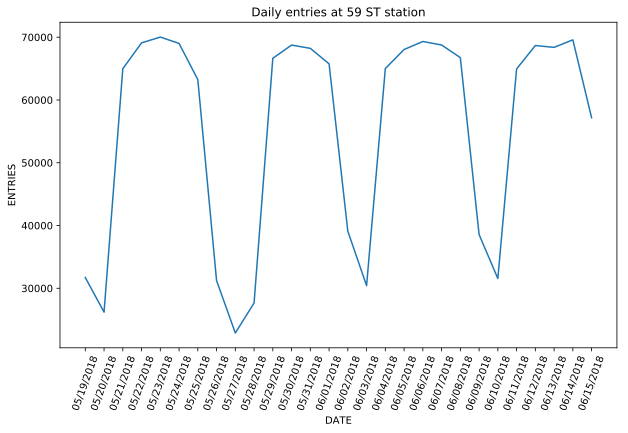

In [25]:
timeseries_station(df_stns)

Select a station and find the total daily counts for this station. Then plot those daily counts for each week separately.

To clarify: if I have 10 weeks of data on the 28th st 6 station, I will add 10 lines to the same figure (e.g. running plt.plot(week_count_list) once for each week). Each plot will have 7 points of data.

## Part 8: Find total daily counts for a station and plot them by week

In [26]:
df_unionsq = df_stns[df_stns['STATION'] == '14 ST-UNION SQ']

In [27]:
df_unionsq = df_unionsq.groupby(['STATION', 'DATE']).sum().reset_index()
df_unionsq.head()

,STATION,DATE,Unnamed: 0,ENTRIES,EXITS
0,14 ST-UNION SQ,05/19/2018,11507646,70419.0,67345.0
1,14 ST-UNION SQ,05/20/2018,11509014,61274.0,56303.0
2,14 ST-UNION SQ,05/21/2018,11510382,103913.0,87543.0
3,14 ST-UNION SQ,05/22/2018,11511750,104525.0,89636.0
4,14 ST-UNION SQ,05/23/2018,11513118,112783.0,95101.0


In [28]:
weeks=[]

In [29]:
dates = df['DATE'].unique()
for _ in range(7, len(dates) + 1, 7):
    weeks.append(dates[_-7:_])

In [30]:
def timeseries_weeks(df, weeks):
    
    for week in weeks:
        sns.lineplot(df[df['DATE'].isin(week)]['DATE'], df['ENTRIES'])
    
    plt.title('Single station entries over four weeks')
    plt.xticks(label=df['DATE'].unique())
    plt.tick_params(axis='x', which='major', rotation=70)

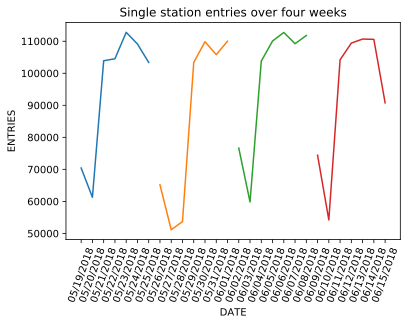

In [31]:
timeseries_weeks(df_unionsq, weeks)

## Part 9: Find total ridership of each station over all data

In [32]:
df_totals = df.groupby('STATION').sum().reset_index()
df_totals.sort_values(by=['ENTRIES'], inplace=True, ascending=False)

In [33]:
df_totals.head()

,STATION,Unnamed: 0,ENTRIES,EXITS
59,34 ST-PENN STA,6233895238,3945653.0,3387234.0
230,GRD CNTRL-42 ST,4771612654,3411785.0,3138436.0
57,34 ST-HERALD SQ,3112688685,2646297.0,2401516.0
14,14 ST-UNION SQ,2188659814,2602866.0,2294447.0
45,23 ST,4403920267,2556586.0,1813530.0


In [34]:
df_totals.drop(labels=['Unnamed: 0'], inplace=True, axis=1)

## Part 10: Plot total ridership over all data by station

In [37]:
def traffic_hist(df):
    plt.hist(df['ENTRIES'], alpha=0.4)
    plt.tick_params(axis='x', which='major', rotation = 70)
    plt.xlabel('Entries')
    plt.ylabel('Number of stations')
    plt.title('Total entries')
    plt.grid(axis='y')

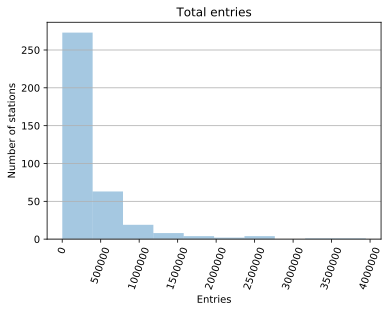

In [38]:
traffic_hist(df_totals)

In [45]:
def traffic_bar(df):
    top20 = df.head(20)
    plt.bar(top20['STATION'], top20['ENTRIES'], alpha=0.4)
    plt.tick_params(axis='x', which='major', rotation = 90)
    plt.xlabel('Station')
    plt.ylabel('Entries')
    plt.title('Top 20 stations by total ridership')
    plt.grid(axis='y')

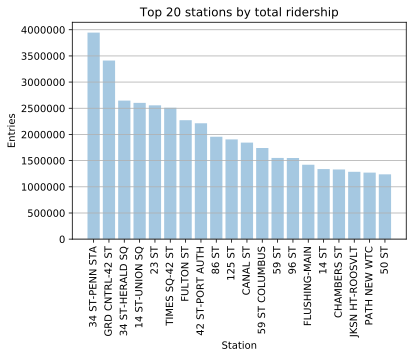

In [46]:
traffic_bar(df_totals)